In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
path = "/content/drive/MyDrive/SCORE - VR vision/Results"
slotsDf = pd.read_csv(os.path.join(path, "clean-data/slots.csv"))
participantsDf = pd.read_csv(os.path.join(path, "clean-data/participants.csv"))
focusTimesDf = pd.read_csv(os.path.join(path, "clean-data/focusTimes.csv"))
expDf = pd.read_csv(os.path.join(path, "clean-data/experiments.csv"))
scoresDf = pd.read_csv(os.path.join(path, "computed-data/scores.csv"))

In [4]:
expDf = (expDf
  .set_index(["participantId","device","datasetId"])
  .join(
      scoresDf
      .set_index(["participantId","device","datasetId"])
  )
  .reset_index())

In [5]:
expDf["sequenceOrder"] = (expDf["experimentOrder"] == 2) | (expDf["experimentOrder"] == 4)

In [8]:
expDf

,participantId,device,datasetId,pauseTime,sortingTime,time,experimentOrder,nbTrue,trueProp,maxTrueStreak,maxFalseStreak,veracityScore,levenDist,sequenceOrder
0,16,VR,1,184.909470,269.096130,2022-04-27 13:36:32,3,6,0.857143,1,1,0.653061,5,False
1,16,VR,2,342.400177,221.314514,2022-04-27 13:49:19,4,4,0.571429,1,1,0.244898,7,True
2,13,VR,2,34.628632,304.130951,2022-04-27 14:43:34,1,3,0.428571,1,1,0.387755,5,False
3,13,VR,1,162.141891,227.080627,2022-04-27 14:54:16,2,5,0.714286,1,1,0.530612,5,True
4,13,Comp,1,370.547791,247.132828,2022-04-27 15:13:53,3,3,0.428571,1,3,0.224490,7,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,15,Comp,2,9.416518,210.855438,2022-05-02 18:29:12,3,4,0.571429,1,1,0.326531,7,False
86,15,Comp,1,6.016559,131.948090,2022-05-02 18:34:39,4,4,0.571429,1,1,0.346939,7,True
87,16,Comp,1,6.350022,250.443741,2022-04-27 13:11:44,1,5,0.714286,1,1,0.591837,6,False
88,16,Comp,2,122.701782,260.243805,2022-04-27 13:22:12,2,2,0.285714,1,1,0.204082,7,True


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3002: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


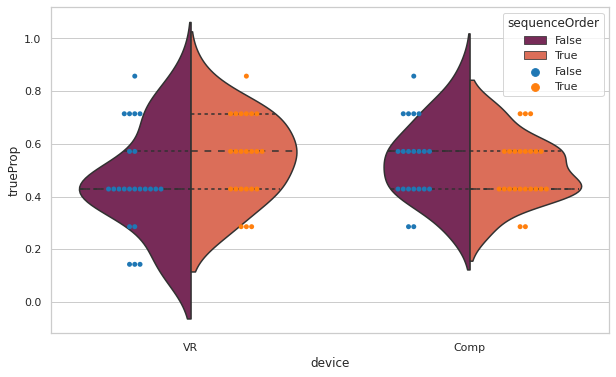

In [110]:
plt.figure(figsize = (10,6))
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x='device', y='trueProp', hue='sequenceOrder', split=True, data=expDf, palette="rocket", inner='quartiles')
ax = sns.swarmplot(x='device', y='trueProp', hue='sequenceOrder', data=expDf, split=True, palette="tab10", edgecolor="grey")

In [51]:
def delta(x):
  x=x.reset_index(drop=True)
  return x.diff()

In [76]:
deltaDf=(pd.DataFrame(expDf
                          .groupby(['participantId','device'])
                          .trueProp
                          .apply(delta))
                                        .rename(columns={"trueProp": "deltaTrueProp"})
                                        .dropna())

In [80]:
deltaDf.groupby('device').deltaTrueProp.mean()

device
Comp   -0.050000
VR      0.086957
Name: deltaTrueProp, dtype: float64

Let's notate $X_i$ the delta in trueProp for VR for participant $i$. n=25

- All the $X_i$ from all groups are independent of each other
- All the $X_i$ from all groups are identically distributed 
- Mean $μ_1$, Variance $σ_1^2$

Let's notate $Y_i$ the delta in trueProp for Computer for participant $i$. n=25

- All the $Y_i$ from all groups are independent of each other
- All the $Y_i$ from all groups are identically distributed
- Mean $μ_2$, Variance $σ_2^2$

$X_i$ and $Y_i$ are independant.

We don't know the distributions of the two populations so we will use the Mann–Whitney U test to see if they fall under the same distribution, and we choose beforehand a nominal value $\alpha = 0.05$

Under the null hypothesis $H_0$, the distributions of both populations are equal, participants have the same progression between the 1st and 2nd experiment on VR and on Computer
The alternative hypothesis $H_1$ is that the distribution of the progression in VR is greater than that of Computer.


In [102]:
deltaVr = deltaDf[deltaDf.index.get_level_values('device') == 'VR']["deltaTrueProp"]
deltaComp = deltaDf[deltaDf.index.get_level_values('device') == 'Comp']["deltaTrueProp"]

res= stats.mannwhitneyu(deltaVr, deltaComp, alternative="greater")
print(res)

MannwhitneyuResult(statistic=311.0, pvalue=0.02338428908413344)


The p-value is lower than 0.05, this means we reject $H_0$ in favor of our alternative, so participants have a greater progression speed in VR than using a Computer.  

In [86]:
print(f"VR : {deltaVr.mean()}, Computer : {deltaComp.mean()}, p-value : {p}")

VR : 0.08695652173913042, Computer : -0.05, p-value : 0.02338428908413344


We will perform a Student's test for the equality of means:

Under the null hypothesis $H_0$, the means of the deltas for both devices are equal.
The alternative hypothesis $H_1$ the mean of the deltas for VR is greater than that of Computer equal.


In [93]:
stats.ttest_ind(deltaVr, deltaComp)

Ttest_indResult(statistic=1.8802306325246028, pvalue=0.06719407329582236)

In [ ]:
correlation, p = []
for i in range(1,len(compDf)):
  correlation[i-1], p[i-1] = corr(compDf[compDf.columns[i-1],compDf.columns[i]])
